# XGBoost with Selected Interval Features (Top 20)

## 목표
- All Interval Features (100+) 중 상위 20개만 선택
- Precision 개선 + Recall 유지
- 해석 가능성 향상

## 전략
1. 타겟 상관관계 기반 필터링
2. Feature importance 기반 선택
3. 도메인 지식 기반 균형 (decline, worst, cross-metric)
4. 중복 제거

## 1. 환경 설정

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    precision_recall_curve,
    auc,
    fbeta_score
)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 2. 데이터 로드

In [25]:
df = pd.read_csv('../data/processed/featured_data_with_intervals.csv')

print(f"Data shape: {df.shape}")
print(f"Date range: {df['TA_YM'].min()} ~ {df['TA_YM'].max()}")

Data shape: (86590, 148)
Date range: 202301 ~ 202412


## 3. Interval Features 추출

In [26]:
# Interval pattern features 추출
interval_keywords = ['decline', 'worst', 'best', 'distance', 'recovery', 'divergence', 'aligned', 'volatility']
interval_features = [col for col in df.columns if any(kw in col for kw in interval_keywords)]

print(f"총 Interval features: {len(interval_features)}개")

# 카테고리별 분류
decline_features = [f for f in interval_features if 'decline' in f]
worst_features = [f for f in interval_features if 'worst' in f or 'best' in f or 'distance' in f]
cross_features = [f for f in interval_features if 'divergence' in f or 'aligned' in f]
recovery_features = [f for f in interval_features if 'recovery' in f or 'volatility' in f]

print(f"\n카테고리별:")
print(f"  - Decline patterns: {len(decline_features)}개")
print(f"  - Historical worst: {len(worst_features)}개")
print(f"  - Cross-metric: {len(cross_features)}개")
print(f"  - Recovery: {len(recovery_features)}개")

총 Interval features: 81개

카테고리별:
  - Decline patterns: 43개
  - Historical worst: 20개
  - Cross-metric: 9개
  - Recovery: 16개


## 4. Feature Selection - 다차원 평가

In [27]:
# Valid training data만 사용
valid_data = df[df['is_valid_for_training'] == 1].copy()

print(f"Valid training data: {len(valid_data):,} rows")

Valid training data: 86,560 rows


### 4.1 타겟 상관관계 분석


Top 30 features by correlation:
RC_M1_SAA_at_worst_now                     0.012590
RC_M1_SAA_total_decline_12m                0.009755
RC_M1_AV_NP_AT_at_worst_now                0.009678
RC_M1_UE_CUS_CN_distance_from_best         0.009669
RC_M1_TO_UE_CT_months_since_best           0.008130
RC_M1_SAA_decline_count_12m                0.008007
RC_M1_SAA_total_decline_6m                 0.007884
RC_M1_SAA_decline_speed_6m                 0.007884
RC_M1_TO_UE_CT_decline_count_12m           0.007773
RC_M1_UE_CUS_CN_at_worst_now               0.007292
RC_M1_TO_UE_CT_best_ever                   0.007283
divergence_RC_M1_SAA_vs_RC_M1_UE_CUS_CN    0.006735
RC_M1_AV_NP_AT_total_decline_6m            0.006553
RC_M1_AV_NP_AT_decline_speed_6m            0.006553
RC_M1_AV_NP_AT_best_ever                   0.006504
RC_M1_SAA_months_since_best                0.006447
RC_M1_SAA_decline_count_3m                 0.006254
RC_M1_AV_NP_AT_decline_count_12m           0.006059
RC_M1_SAA_consecutive_recovery 

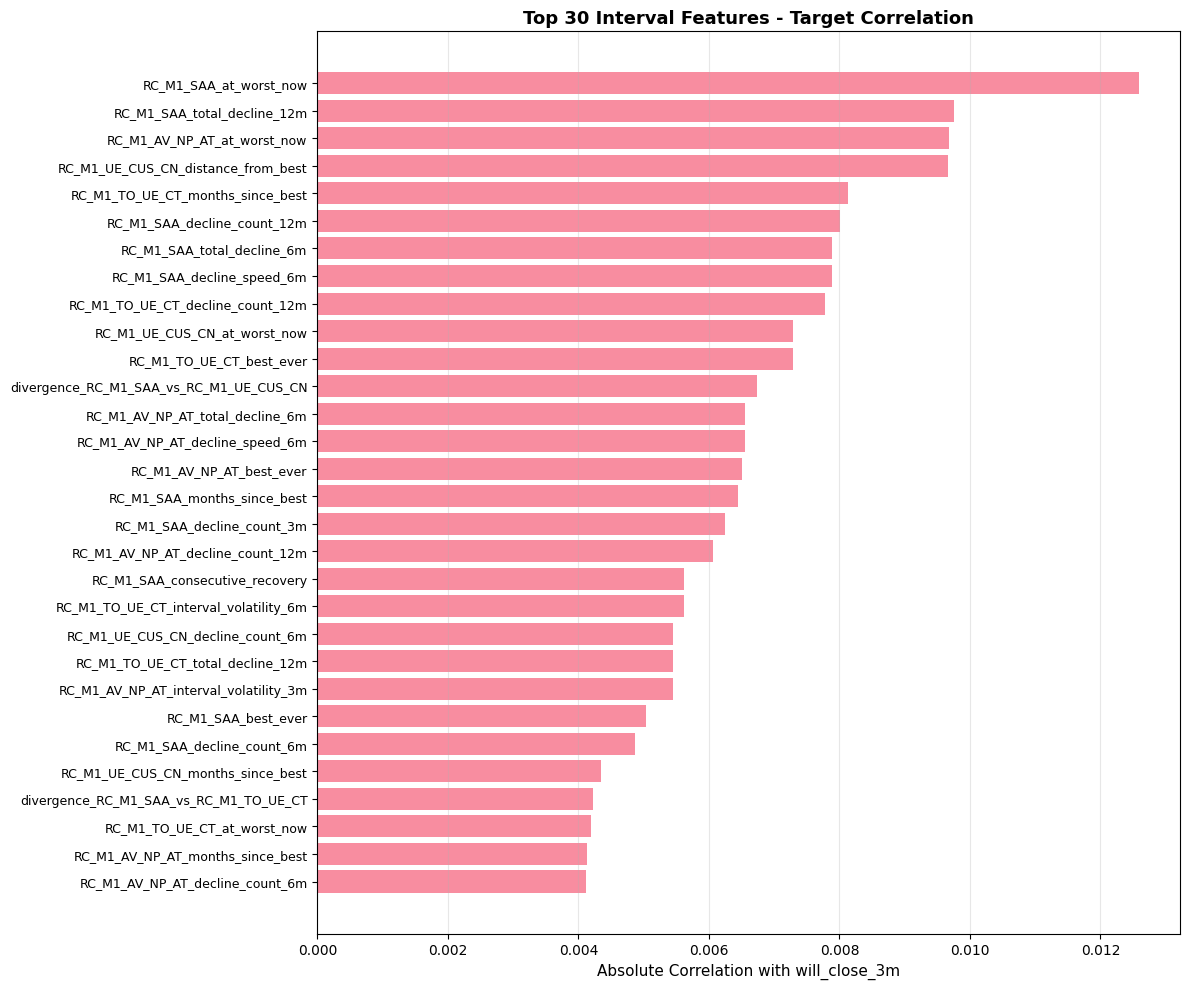

In [28]:
# 타겟 변수와의 상관관계
correlations = valid_data[interval_features].corrwith(valid_data['will_close_3m']).abs().sort_values(ascending=False)

print("\nTop 30 features by correlation:")
print(correlations.head(30))

# 시각화
fig, ax = plt.subplots(figsize=(12, 10))
top_30 = correlations.head(30)
ax.barh(range(len(top_30)), top_30.values, alpha=0.8)
ax.set_yticks(range(len(top_30)))
ax.set_yticklabels([f[:60] for f in top_30.index], fontsize=9)
ax.set_xlabel('Absolute Correlation with will_close_3m', fontsize=11)
ax.set_title('Top 30 Interval Features - Target Correlation', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2 결측값 및 분산 확인

In [29]:
# 결측값 비율
missing_ratio = valid_data[interval_features].isnull().mean()
low_missing = missing_ratio[missing_ratio < 0.3]

print(f"결측값 <30%인 features: {len(low_missing)}개")

# 분산
variances = valid_data[interval_features].var()
high_var = variances[variances > variances.quantile(0.1)]  # 하위 10% 제외

print(f"충분한 분산을 가진 features: {len(high_var)}개")

결측값 <30%인 features: 77개
충분한 분산을 가진 features: 72개


### 4.3 통합 후보군 선정

In [30]:
# 기준: 상관관계 top 40 & 결측 적음 & 분산 충분
top_corr_features = set(correlations.head(40).index)
candidates = top_corr_features & set(low_missing.index) & set(high_var.index)

print(f"\n후보 features (모든 조건 만족): {len(candidates)}개")
print(f"\n후보 목록:")
for i, f in enumerate(sorted(candidates), 1):
    corr = correlations[f]
    print(f"  {i:2d}. {f[:70]:70s} (corr={corr:.4f})")


후보 features (모든 조건 만족): 33개

후보 목록:
   1. RC_M1_AV_NP_AT_at_worst_now                                            (corr=0.0097)
   2. RC_M1_AV_NP_AT_best_ever                                               (corr=0.0065)
   3. RC_M1_AV_NP_AT_decline_count_12m                                       (corr=0.0061)
   4. RC_M1_AV_NP_AT_decline_count_3m                                        (corr=0.0033)
   5. RC_M1_AV_NP_AT_decline_count_6m                                        (corr=0.0041)
   6. RC_M1_AV_NP_AT_interval_volatility_3m                                  (corr=0.0055)
   7. RC_M1_AV_NP_AT_months_since_best                                       (corr=0.0041)
   8. RC_M1_AV_NP_AT_recovery_after_decline                                  (corr=0.0040)
   9. RC_M1_AV_NP_AT_total_decline_6m                                        (corr=0.0066)
  10. RC_M1_SAA_at_worst_now                                                 (corr=0.0126)
  11. RC_M1_SAA_best_ever                            

### 4.4 최종 선택: 카테고리별 균형

In [31]:
# 카테고리별 균형있게 선택 (총 20개 목표)
selected_features = []

# A. Decline patterns (10개) - 가장 중요
decline_candidates = [f for f in candidates if f in decline_features]
selected_decline = sorted(decline_candidates, key=lambda x: correlations[x], reverse=True)[:10]
selected_features.extend(selected_decline)

print(f"✅ Selected Decline features ({len(selected_decline)}개):")
for f in selected_decline:
    print(f"   - {f} (corr={correlations[f]:.4f})")

# B. Historical worst (4개)
worst_candidates = [f for f in candidates if f in worst_features]
selected_worst = sorted(worst_candidates, key=lambda x: correlations[x], reverse=True)[:4]
selected_features.extend(selected_worst)

print(f"\n✅ Selected Historical worst features ({len(selected_worst)}개):")
for f in selected_worst:
    print(f"   - {f} (corr={correlations[f]:.4f})")

# C. Cross-metric (4개)
cross_candidates = [f for f in candidates if f in cross_features]
selected_cross = sorted(cross_candidates, key=lambda x: correlations[x], reverse=True)[:4]
selected_features.extend(selected_cross)

print(f"\n✅ Selected Cross-metric features ({len(selected_cross)}개):")
for f in selected_cross:
    print(f"   - {f} (corr={correlations[f]:.4f})")

# D. Recovery (2개)
recovery_candidates = [f for f in candidates if f in recovery_features]
selected_recovery = sorted(recovery_candidates, key=lambda x: correlations[x], reverse=True)[:2]
selected_features.extend(selected_recovery)

print(f"\n✅ Selected Recovery features ({len(selected_recovery)}개):")
for f in selected_recovery:
    print(f"   - {f} (corr={correlations[f]:.4f})")

# 중복 제거
selected_features = list(set(selected_features))

print(f"\n" + "="*80)
print(f"최종 선택된 features: {len(selected_features)}개")
print("="*80)

✅ Selected Decline features (10개):
   - RC_M1_SAA_decline_count_12m (corr=0.0080)
   - RC_M1_SAA_total_decline_6m (corr=0.0079)
   - RC_M1_TO_UE_CT_decline_count_12m (corr=0.0078)
   - RC_M1_AV_NP_AT_total_decline_6m (corr=0.0066)
   - RC_M1_SAA_decline_count_3m (corr=0.0063)
   - RC_M1_AV_NP_AT_decline_count_12m (corr=0.0061)
   - RC_M1_UE_CUS_CN_decline_count_6m (corr=0.0055)
   - RC_M1_SAA_decline_count_6m (corr=0.0049)
   - RC_M1_AV_NP_AT_decline_count_6m (corr=0.0041)
   - RC_M1_SAA_consecutive_declines (corr=0.0040)

✅ Selected Historical worst features (4개):
   - RC_M1_SAA_at_worst_now (corr=0.0126)
   - RC_M1_AV_NP_AT_at_worst_now (corr=0.0097)
   - RC_M1_UE_CUS_CN_distance_from_best (corr=0.0097)
   - RC_M1_TO_UE_CT_months_since_best (corr=0.0081)

✅ Selected Cross-metric features (3개):
   - divergence_RC_M1_SAA_vs_RC_M1_UE_CUS_CN (corr=0.0067)
   - divergence_RC_M1_SAA_vs_RC_M1_TO_UE_CT (corr=0.0042)
   - divergence_RC_M1_SAA_vs_RC_M1_AV_NP_AT (corr=0.0040)

✅ Selected Recove

## 5. 데이터 분할

In [32]:
# Valid training data
df_train = df[df['is_valid_for_training'] == 1].copy()

# Train / Valid / Test split
train_mask = df_train['TA_YM'] <= 202406
valid_mask = (df_train['TA_YM'] > 202406) & (df_train['TA_YM'] <= 202409)
test_mask = df_train['TA_YM'] > 202409

print("Data split:")
print(f"  Train: {train_mask.sum():,} rows")
print(f"  Valid: {valid_mask.sum():,} rows")
print(f"  Test:  {test_mask.sum():,} rows")

Data split:
  Train: 62,257 rows
  Valid: 11,933 rows
  Test:  12,370 rows


In [33]:
# Features & Target
X_train = df_train[train_mask][selected_features]
y_train = df_train[train_mask]['will_close_3m']

X_valid = df_train[valid_mask][selected_features]
y_valid = df_train[valid_mask]['will_close_3m']

X_test = df_train[test_mask][selected_features]
y_test = df_train[test_mask]['will_close_3m']

print(f"\nFeature count: {len(selected_features)}")
print(f"\nTrain target distribution:")
print(y_train.value_counts())
print(f"Class imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")


Feature count: 19

Train target distribution:
will_close_3m
0    62183
1       74
Name: count, dtype: int64
Class imbalance ratio: 840.3:1


## 6. XGBoost 모델 학습

In [34]:
# Class imbalance 처리
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale positive weight: {scale_pos_weight:.1f}")

Scale positive weight: 840.3


In [35]:
# XGBoost 모델
model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=5,
    learning_rate=0.05,
    n_estimators=500,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    eval_metric='aucpr',
    random_state=42,
    tree_method='hist'
)

print("✅ XGBoost model initialized")

✅ XGBoost model initialized


In [36]:
# 학습
print("Training XGBoost with selected features...\n")

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=20
)

print("\n✅ Training completed!")

Training XGBoost with selected features...

[0]	validation_0-aucpr:0.01282	validation_1-aucpr:0.00174
[20]	validation_0-aucpr:0.02229	validation_1-aucpr:0.00219
[40]	validation_0-aucpr:0.02637	validation_1-aucpr:0.00259
[60]	validation_0-aucpr:0.06517	validation_1-aucpr:0.00340
[80]	validation_0-aucpr:0.07786	validation_1-aucpr:0.00345
[100]	validation_0-aucpr:0.07296	validation_1-aucpr:0.00400
[120]	validation_0-aucpr:0.13243	validation_1-aucpr:0.00394
[140]	validation_0-aucpr:0.13651	validation_1-aucpr:0.00421
[160]	validation_0-aucpr:0.15783	validation_1-aucpr:0.00422
[180]	validation_0-aucpr:0.16707	validation_1-aucpr:0.00468
[200]	validation_0-aucpr:0.17167	validation_1-aucpr:0.00480
[220]	validation_0-aucpr:0.20547	validation_1-aucpr:0.00482
[240]	validation_0-aucpr:0.22828	validation_1-aucpr:0.00493
[260]	validation_0-aucpr:0.22546	validation_1-aucpr:0.00516
[280]	validation_0-aucpr:0.23065	validation_1-aucpr:0.00521
[300]	validation_0-aucpr:0.22681	validation_1-aucpr:0.00539
[3

## 7. 모델 평가

In [37]:
# 예측
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]

y_valid_pred = model.predict(X_valid)
y_valid_proba = model.predict_proba(X_valid)[:, 1]

y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("✅ Predictions generated")

✅ Predictions generated


### 7.1 Train Set

In [38]:
print("="*80)
print("Train Set Evaluation")
print("="*80)

train_roc_auc = roc_auc_score(y_train, y_train_proba)
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
train_pr_auc = auc(recall_train, precision_train)

print(f"\nROC-AUC: {train_roc_auc:.4f}")
print(f"PR-AUC: {train_pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

cm_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:")
print(cm_train)

Train Set Evaluation

ROC-AUC: 0.9770
PR-AUC: 0.2885

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     62183
           1       0.01      0.97      0.01        74

    accuracy                           0.84     62257
   macro avg       0.50      0.91      0.46     62257
weighted avg       1.00      0.84      0.91     62257

Confusion Matrix:
[[52153 10030]
 [    2    72]]


### 7.2 Validation Set

In [39]:
print("="*80)
print("Validation Set Evaluation")
print("="*80)

valid_roc_auc = roc_auc_score(y_valid, y_valid_proba)
precision_valid, recall_valid, _ = precision_recall_curve(y_valid, y_valid_proba)
valid_pr_auc = auc(recall_valid, precision_valid)

print(f"\nROC-AUC: {valid_roc_auc:.4f}")
print(f"PR-AUC: {valid_pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_valid, y_valid_pred))

cm_valid = confusion_matrix(y_valid, y_valid_pred)
print("Confusion Matrix:")
print(cm_valid)
print(f"\nDetection: {cm_valid[1,1]}/{(y_valid == 1).sum()} ({cm_valid[1,1] / (y_valid == 1).sum() * 100:.1f}%)")

Validation Set Evaluation

ROC-AUC: 0.6660
PR-AUC: 0.0056

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     11922
           1       0.01      0.55      0.01        11

    accuracy                           0.93     11933
   macro avg       0.50      0.74      0.49     11933
weighted avg       1.00      0.93      0.96     11933

Confusion Matrix:
[[11113   809]
 [    5     6]]

Detection: 6/11 (54.5%)


### 7.3 Test Set (핵심)

In [40]:
print("="*80)
print("Test Set Evaluation (MAIN RESULT)")
print("="*80)

test_roc_auc = roc_auc_score(y_test, y_test_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
test_pr_auc = auc(recall_test, precision_test)

print(f"\nROC-AUC: {test_roc_auc:.4f}")
print(f"PR-AUC: {test_pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm_test)
print(f"\nTrue Positives: {cm_test[1,1]}")
print(f"False Positives: {cm_test[0,1]}")
print(f"False Negatives: {cm_test[1,0]}")
print(f"True Negatives: {cm_test[0,0]}")
print(f"\nDetection Rate: {cm_test[1,1]}/{(y_test == 1).sum()} ({cm_test[1,1] / (y_test == 1).sum() * 100:.1f}%)")

Test Set Evaluation (MAIN RESULT)

ROC-AUC: 0.6502
PR-AUC: 0.0017

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     12359
           1       0.00      0.27      0.01        11

    accuracy                           0.94     12370
   macro avg       0.50      0.61      0.49     12370
weighted avg       1.00      0.94      0.97     12370


Confusion Matrix:
[[11637   722]
 [    8     3]]

True Positives: 3
False Positives: 722
False Negatives: 8
True Negatives: 11637

Detection Rate: 3/11 (27.3%)


### 7.4 결과 요약

In [41]:
results = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'ROC-AUC': [train_roc_auc, valid_roc_auc, test_roc_auc],
    'PR-AUC': [train_pr_auc, valid_pr_auc, test_pr_auc],
    'Detection (TP)': [cm_train[1,1], cm_valid[1,1], cm_test[1,1]],
    'Total Positive': [(y_train==1).sum(), (y_valid==1).sum(), (y_test==1).sum()],
    'Detection Rate (%)': [
        cm_train[1,1]/(y_train==1).sum()*100,
        cm_valid[1,1]/(y_valid==1).sum()*100,
        cm_test[1,1]/(y_test==1).sum()*100
    ],
    'False Positives': [cm_train[0,1], cm_valid[0,1], cm_test[0,1]]
})

print("\n" + "="*80)
print("RESULTS SUMMARY - Selected Interval Features (Top 20)")
print("="*80)
print(results.to_string(index=False))
print("="*80)


RESULTS SUMMARY - Selected Interval Features (Top 20)
   Dataset  ROC-AUC   PR-AUC  Detection (TP)  Total Positive  Detection Rate (%)  False Positives
     Train 0.976956 0.288507              72              74           97.297297            10030
Validation 0.665984 0.005641               6              11           54.545455              809
      Test 0.650214 0.001707               3              11           27.272727              722


## 8. Feature Importance

In [42]:
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(importance_df.to_string(index=False))


Feature Importance:
                                feature  importance
             RC_M1_SAA_decline_count_3m    0.091678
divergence_RC_M1_SAA_vs_RC_M1_UE_CUS_CN    0.074944
            RC_M1_SAA_decline_count_12m    0.061162
     RC_M1_UE_CUS_CN_distance_from_best    0.058476
        RC_M1_AV_NP_AT_total_decline_6m    0.057705
  RC_M1_TO_UE_CT_interval_volatility_6m    0.054396
 divergence_RC_M1_SAA_vs_RC_M1_TO_UE_CT    0.053659
                 RC_M1_SAA_at_worst_now    0.053422
             RC_M1_SAA_total_decline_6m    0.052427
       RC_M1_TO_UE_CT_months_since_best    0.052228
       RC_M1_TO_UE_CT_decline_count_12m    0.049002
         RC_M1_SAA_consecutive_recovery    0.047928
       RC_M1_AV_NP_AT_decline_count_12m    0.046627
 divergence_RC_M1_SAA_vs_RC_M1_AV_NP_AT    0.045920
       RC_M1_UE_CUS_CN_decline_count_6m    0.044997
             RC_M1_SAA_decline_count_6m    0.043957
        RC_M1_AV_NP_AT_decline_count_6m    0.041445
            RC_M1_AV_NP_AT_at_worst_now    

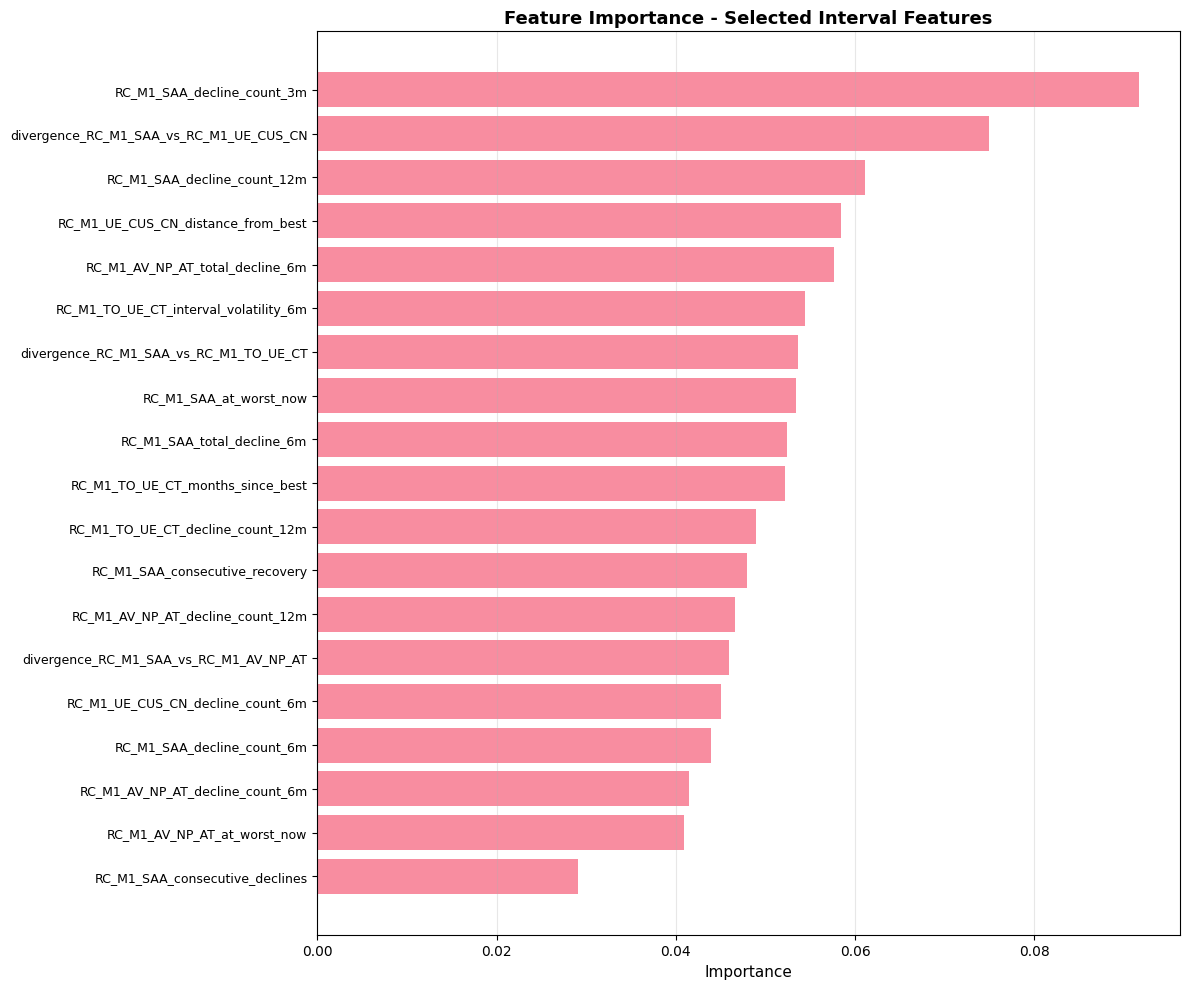

In [43]:
# 시각화
fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(range(len(importance_df)), importance_df['importance'].values, alpha=0.8)
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels([f[:60] for f in importance_df['feature'].values], fontsize=9)
ax.set_xlabel('Importance', fontsize=11)
ax.set_title('Feature Importance - Selected Interval Features', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 9. 이전 모델들과 비교

In [44]:
# 비교 테이블
comparison = pd.DataFrame({
    'Model': [
        'Original (No Interval)',
        'All Interval (100+)',
        'Decline Only (36)',
        'Selected Interval (20)'
    ],
    'Test ROC-AUC': [0.7519, 0.6980, 0.6932, test_roc_auc],
    'Test PR-AUC': [0.0499, 0.0261, 0.0018, test_pr_auc],
    'Detection': ['1/22', '4/22', '3/11', f"{cm_test[1,1]}/{(y_test==1).sum()}"],
    'Detection Rate (%)': [4.5, 18.2, 27.3, cm_test[1,1]/(y_test==1).sum()*100],
    'False Positives': [32, '~수백개', 1323, cm_test[0,1]]
})

print("\n" + "="*100)
print("🔥 모델 비교: Selected Interval Features의 성능")
print("="*100)
print(comparison.to_string(index=False))
print("="*100)

# 개선 여부 판단
print("\n📊 분석:")
if test_roc_auc > 0.6980:
    print(f"  ✅ ROC-AUC 개선: 0.6980 → {test_roc_auc:.4f} (+{test_roc_auc - 0.6980:.4f})")
else:
    print(f"  ⚠️  ROC-AUC 변화: 0.6980 → {test_roc_auc:.4f} ({test_roc_auc - 0.6980:+.4f})")

if test_pr_auc > 0.0261:
    print(f"  ✅ PR-AUC 개선: 0.0261 → {test_pr_auc:.4f} (+{test_pr_auc - 0.0261:.4f})")
else:
    print(f"  ⚠️  PR-AUC 변화: 0.0261 → {test_pr_auc:.4f} ({test_pr_auc - 0.0261:+.4f})")

print(f"  📍 Detection: {cm_test[1,1]}/{(y_test==1).sum()} 탐지")
print(f"  📍 False Positives: {cm_test[0,1]}개")


🔥 모델 비교: Selected Interval Features의 성능
                 Model  Test ROC-AUC  Test PR-AUC Detection  Detection Rate (%) False Positives
Original (No Interval)      0.751900     0.049900      1/22            4.500000              32
   All Interval (100+)      0.698000     0.026100      4/22           18.200000            ~수백개
     Decline Only (36)      0.693200     0.001800      3/11           27.300000            1323
Selected Interval (20)      0.650214     0.001707      3/11           27.272727             722

📊 분석:
  ⚠️  ROC-AUC 변화: 0.6980 → 0.6502 (-0.0478)
  ⚠️  PR-AUC 변화: 0.0261 → 0.0017 (-0.0244)
  📍 Detection: 3/11 탐지
  📍 False Positives: 722개


## 10. 최종 리포트

In [45]:
print("\n" + "="*80)
print("FINAL REPORT - XGBoost with Selected Interval Features")
print("="*80)

print(f"\n📊 Feature Selection Strategy:")
print(f"   - Total selected: {len(selected_features)} features")
print(f"   - Decline patterns: {len(selected_decline)}")
print(f"   - Historical worst: {len(selected_worst)}")
print(f"   - Cross-metric: {len(selected_cross)}")
print(f"   - Recovery: {len(selected_recovery)}")

print(f"\n🎯 Test Set Performance:")
print(f"   - ROC-AUC: {test_roc_auc:.4f}")
print(f"   - PR-AUC: {test_pr_auc:.4f}")
print(f"   - Detection Rate: {cm_test[1,1]}/{(y_test==1).sum()} ({cm_test[1,1]/(y_test==1).sum()*100:.1f}%)")
print(f"   - False Positives: {cm_test[0,1]}")
print(f"   - Precision: {cm_test[1,1]/(cm_test[1,1]+cm_test[0,1]) if (cm_test[1,1]+cm_test[0,1]) > 0 else 0:.4f}")

print(f"\n🔝 Top 5 Important Features:")
for idx, row in importance_df.head(5).iterrows():
    print(f"   {row['feature'][:70]}: {row['importance']:.4f}")

print(f"\n✅ Model saved")
print("="*80)


FINAL REPORT - XGBoost with Selected Interval Features

📊 Feature Selection Strategy:
   - Total selected: 19 features
   - Decline patterns: 10
   - Historical worst: 4
   - Cross-metric: 3
   - Recovery: 2

🎯 Test Set Performance:
   - ROC-AUC: 0.6502
   - PR-AUC: 0.0017
   - Detection Rate: 3/11 (27.3%)
   - False Positives: 722
   - Precision: 0.0041

🔝 Top 5 Important Features:
   RC_M1_SAA_decline_count_3m: 0.0917
   divergence_RC_M1_SAA_vs_RC_M1_UE_CUS_CN: 0.0749
   RC_M1_SAA_decline_count_12m: 0.0612
   RC_M1_UE_CUS_CN_distance_from_best: 0.0585
   RC_M1_AV_NP_AT_total_decline_6m: 0.0577

✅ Model saved


## 11. 모델 저장

In [46]:
import json
import pickle
from pathlib import Path

models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# 1. XGBoost JSON 형식 저장 (XGBoost 네이티브)
model.save_model(str(models_dir / 'xgboost_selected_interval.json'))

# 2. Pickle 파일 저장 (Python 호환성)
with open(models_dir / 'xgboost_selected_interval.pkl', 'wb') as f:
    pickle.dump(model, f)

# 3. Feature 정보 저장
model_info = {
    'model_type': 'XGBoost',
    'feature_selection_strategy': 'Top 20 by correlation + domain balance',
    'features': selected_features,
    'feature_count': len(selected_features),
    'feature_breakdown': {
        'decline': len(selected_decline),
        'worst': len(selected_worst),
        'cross': len(selected_cross),
        'recovery': len(selected_recovery)
    },
    'test_roc_auc': float(test_roc_auc),
    'test_pr_auc': float(test_pr_auc),
    'test_detection_rate': float(cm_test[1,1] / (y_test == 1).sum()),
    'test_false_positives': int(cm_test[0,1]),
    'feature_importance': importance_df.to_dict('records')
}

with open(models_dir / 'xgboost_selected_interval_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("✅ Model saved successfully in multiple formats!")
print(f"   - XGBoost format: {models_dir / 'xgboost_selected_interval.json'}")
print(f"   - Pickle format:  {models_dir / 'xgboost_selected_interval.pkl'}")
print(f"   - Model info:     {models_dir / 'xgboost_selected_interval_info.json'}")

✅ Model saved successfully in multiple formats!
   - XGBoost format: ../models/xgboost_selected_interval.json
   - Pickle format:  ../models/xgboost_selected_interval.pkl
   - Model info:     ../models/xgboost_selected_interval_info.json
